# &#x1F4D1; &nbsp; TensorFlow  Cookbook 
## 0. Code Library and Links

In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Orbitron');
body {background-color: gainsboro;} 
a {color: darkgreen; font-family: 'Orbitron';} 
h1 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;} 
h2, h3 {color: darkslategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;}
</style>

In [39]:
import numpy as np 
import pandas as pd
from collections import namedtuple

import cv2
from PIL import ImageFile
from tqdm import tqdm
from keras.preprocessing import image as keras_image
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import tensorflow as tf
import tflearn

In [19]:
import tflearn.datasets.mnist as mnist
from tflearn.data_utils import build_hdf5_image_dataset

## 1. Data Sets

In [44]:
# MNIST
X_train, y_train, X_test, y_test = mnist.load_data(one_hot=True)

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [45]:
[X_train.shape, y_train.shape, X_test.shape, y_test.shape]

[(55000, 784), (55000, 10), (10000, 784), (10000, 10)]

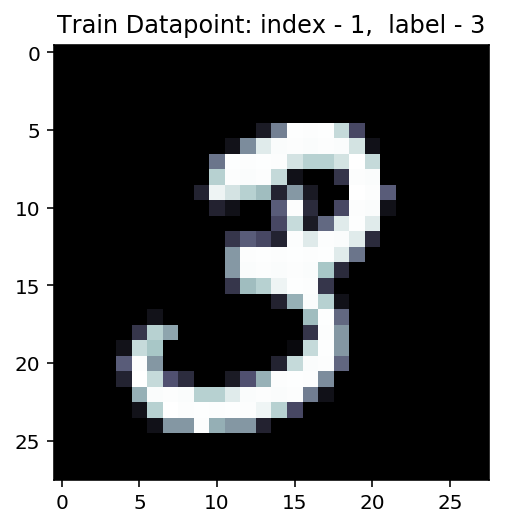

In [44]:
def display_digit(index):
    label = y_train[index].argmax(axis=0)
    image = X_train[index].reshape(28,28)
    plt.title('Train Datapoint: index - %d,  label - %d' % (index, label))
    plt.imshow(image, cmap=cm.bone)

display_digit(1)

In [47]:
# Anna Karenina Text
with open('anna.txt', 'r') as f:
    text=f.read()
vocabulary = set(text)
int_to_vocab = dict(enumerate(vocabulary))
vocab_to_int = dict((v,k) for k,v in int_to_vocab.items())
characters = np.array([vocab_to_int[c] for c in text], dtype=np.int32)

In [48]:
text[:109]

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverything was in '

In [49]:
characters[:109]

array([ 7, 61, 67, 20, 19, 81, 21, 36, 65, 30, 30, 30, 48, 67, 20, 20, 63,
       36, 70, 67, 10, 37, 17, 37, 81, 72, 36, 67, 21, 81, 36, 67, 17, 17,
       36, 67, 17, 37, 31, 81, 56, 36, 81, 46, 81, 21, 63, 36, 76,  1, 61,
       67, 20, 20, 63, 36, 70, 67, 10, 37, 17, 63, 36, 37, 72, 36, 76,  1,
       61, 67, 20, 20, 63, 36, 37,  1, 36, 37, 19, 72, 36,  8, 22,  1, 30,
       22, 67, 63, 44, 30, 30, 77, 46, 81, 21, 63, 19, 61, 37,  1,  3, 36,
       22, 67, 72, 36, 37,  1, 36], dtype=int32)

In [67]:
batch_size, num_steps, split_fraction = 100, 100, 0.9

slice_size = batch_size * num_steps
n_batches = int(len(characters) / slice_size)
# targets = features,  shifted one character over
X2 = characters[: n_batches*slice_size]
y2 = characters[1: n_batches*slice_size + 1]

X2 = np.stack(np.split(X2, batch_size))
y2 = np.stack(np.split(y2, batch_size))

split_id = int(n_batches*split_fraction)
X_train2, y_train2= X2[:, :split_id*num_steps], y2[:, :split_id*num_steps]
X_test2, y_test2 = X2[:, split_id*num_steps:], y2[:, split_id*num_steps:]    

In [68]:
[X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape]

[(100, 17800), (100, 17800), (100, 2000), (100, 2000)]

In [34]:
# 128x128 color images
flowers = pd.read_csv("flower_images/flower_labels.csv")
flower_files = flowers['file']
flower_targets = flowers['label'].as_matrix()

def path_to_tensor(img_path):
    img = keras_image.load_img("flower_images/"+img_path, target_size=(128, 128))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

ImageFile.LOAD_TRUNCATED_IMAGES = True                 
flower_tensors = paths_to_tensor(flower_files);


100%|██████████| 210/210 [00:01<00:00, 156.49it/s]

Label:  0


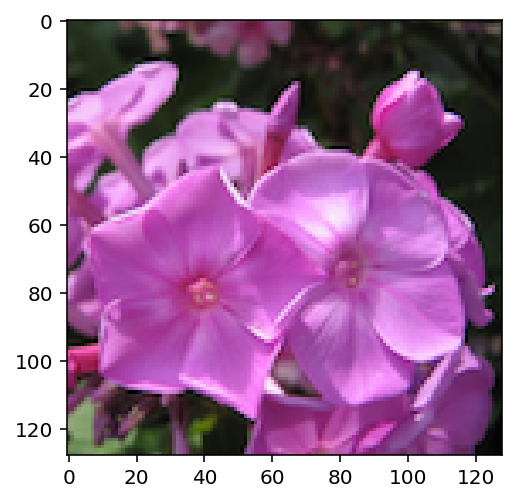

In [37]:
print('Label: ', flower_targets[1])
flower_image = cv2.imread('flower_images/'+flower_files[1])
rgb_flower_image = cv2.cvtColor(flower_image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_flower_image);

In [42]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(flower_tensors, flower_targets, 
                                                        test_size = 0.1, random_state = 1)
X_train3 = X_train3.astype('float32')/255
X_test3 = X_test3.astype('float32')/255

c_y_train3 = to_categorical(y_train3, 10)
c_y_test3 = to_categorical(y_test3, 10)
[X_train3.shape, c_y_train3.shape, X_test3.shape, c_y_test3.shape]

[(189, 128, 128, 3), (189, 10), (21, 128, 128, 3), (21, 10)]

## 2. Basics

## 3. Neural Networks; TensorFlow
### MLP

### CNN

### RNN 

## 4. Neural Networks; Tflearn
### MLP

In [67]:
def mlp_mc_model():
    tf.reset_default_graph()
    
    nn = tflearn.input_data([None, 784])
    
    nn = tflearn.fully_connected(nn, 784, activation='ReLU')    
    nn = tflearn.fully_connected(nn, 392, activation='ReLU')
    
    nn = tflearn.fully_connected(nn, 10, activation='Softmax')
    
    acc = tflearn.metrics.Accuracy()
    nn = tflearn.regression(nn, optimizer='adam', learning_rate=0.01, 
                            loss='categorical_crossentropy', metric=acc)
    model = tflearn.DNN(nn)
    return model

mlp_mc_model = mlp_mc_model()

In [68]:
mlp_mc_model.fit(X_train, y_train, validation_set=0.1, show_metric=True, batch_size=128, n_epoch=30)

Training Step: 11609  | total loss: 1.64038 | time: 12.453s
| Adam | epoch: 030 | loss: 1.64038 - acc: 0.9167 -- iter: 49408/49500
Training Step: 11610  | total loss: 1.47882 | time: 13.489s
| Adam | epoch: 030 | loss: 1.47882 - acc: 0.9242 | val_loss: 0.20089 - val_acc: 0.9687 -- iter: 49500/49500
--


In [69]:
y_test_mlp = np.array(mlp_model.predict(X_test)).argmax(axis=1)
y_test_num = y_test.argmax(axis=1)

test_accuracy_mlp = np.mean(y_test_mlp == y_test_num, axis=0)

print("Test Accuracy: {} %".format(test_accuracy_mlp*100))

Test Accuracy: 95.53 %


### CNN

### RNN